`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


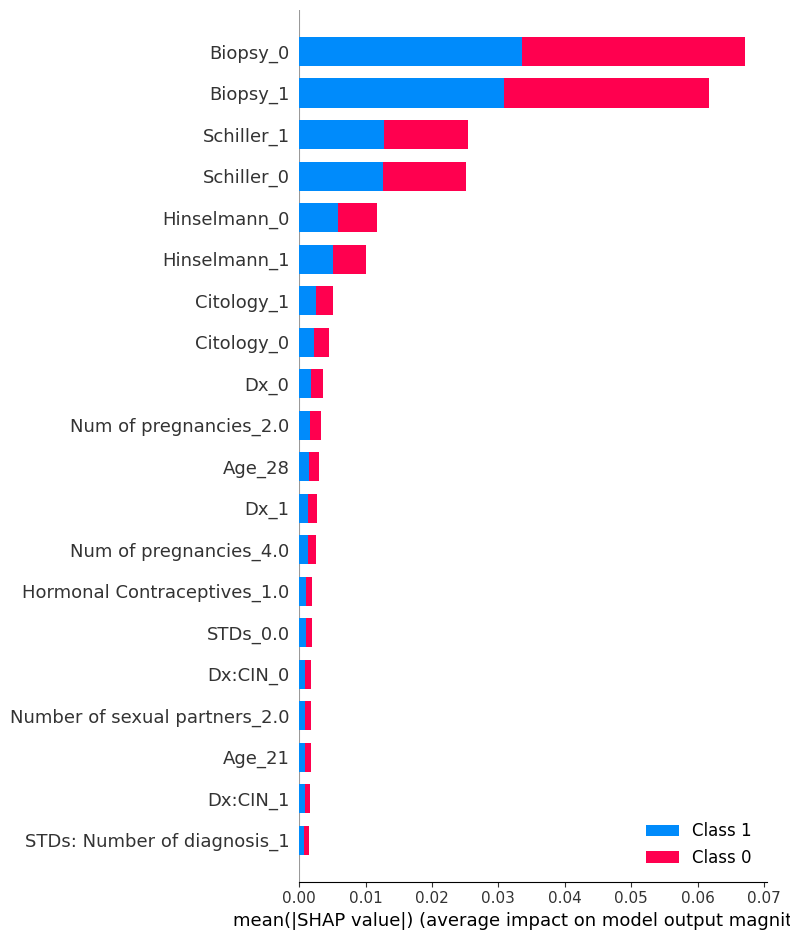

In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

# Load cervical cancer dataset from the UCI repository
url_cervical = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
data = pd.read_csv(url_cervical)
data = data.replace('?', np.nan)
# Display the first few rows of the dataset for a quick overview
data.head()

# Impute missing values for both numeric and categorical data
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Encode categorical data
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data_imputed.select_dtypes(include=['object']))

# Get feature names from encoder
encoded_feature_names = encoder.get_feature_names_out(data_imputed.select_dtypes(include=['object']).columns)

# Combine numeric and encoded categorical data
numeric_data = data_imputed.select_dtypes(exclude=['object'])
X = np.hstack([numeric_data, data_encoded])
feature_names = np.concatenate([numeric_data.columns, encoded_feature_names])

# Separate features and target
y = data_imputed['Biopsy'].astype(int)  # Ensure the target variable is of type int
X = np.delete(X, np.where(feature_names == 'Biopsy')[0], axis=1)  # Remove the target variable from features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Apply TreeSHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
